# Causal Inference of Apple Stock Drop with Time Series Forecasting

## Author:
- Tanish Naik (naik.tan@northeastern.edu)



## Abstract

This notebook provides a causal analysis of the impact of Apple's significant stock price movements during the COVID-19 pandemic, using time series forecasting and counterfactual methods. By constructing a counterfactual from comparable periods and employing advanced forecasting techniques, the study seeks to quantify the effects of the pandemic on Apple's stock performance. The analysis navigates through data preprocessing challenges and employs robust statistical techniques to provide a detailed understanding of the stock's behavior in response to market disruptions, delivering valuable insights for investors and analysts.


## Introduction
This analysis estimates the impact of Apple's significant stock movements during notable events, such as the COVID-19 pandemic. It uses data preparation and causal inference techniques, including building counterfactuals using data from comparable periods and industries. The notebook includes data preprocessing, exploratory data analysis, and time series forecasting, with a summary of findings at the end.

Apple's stock experienced a decline in March 2020 due to market uncertainty and economic disruptions caused by the pandemic. However, it quickly recovered due to increased demand for technology products, remote work adaptation, and continued product innovation, resulting in a significant growth in stock price throughout 2020 and beyond.



### Understanding Causal Inference

Causal inference is the process of determining cause-and-effect relationships from data. It aims to understand whether an action or intervention directly leads to a particular effect, rather than merely being correlated with it.

### Key Principles:

- **Cause-and-Effect**: The fundamental concept of causal inference is to differentiate between causation and correlation. It seeks to establish that one event directly causes another, rather than simply being associated with it.

  
- **Counterfactual Reasoning**: This involves considering what would have happened if the cause had not occurred, which is essential for establishing a causal link.

- **Randomized Experiments**: Often considered the gold standard for causal inference, randomized controlled trials randomly assign subjects to treatment or control groups to isolate the effect of the treatment.

### Methods and Techniques:

- **Observational Studies**: When randomized experiments are not possible, observational data is used, but these studies must carefully control for confounders—variables that could affect both the cause and the effect.
  
- **Statistical Models**: Regression analysis, structural equation modeling, and other statistical techniques are employed to estimate causal effects, often adjusting for potential confounders.

- **Econometric Methods**: Instrumental variables, difference-in-differences, and regression discontinuity designs are among the econometric methods used to infer causality.

### Challenges:

- **Confounding Variables**: A major challenge in observational studies is identifying and controlling for all potential confounders that could bias the results.
  
- **External Validity**: Even when a causal relationship is established, it may not hold in different settings or populations.

### Applications:

- **Policy Evaluation**: Assessing the impact of policy interventions on social and economic outcomes.
  
- **Medicine**: Determining the effectiveness of treatments and interventions.

- **Business**: Evaluating the impact of strategic decisions, marketing campaigns, and other business actions.

In [262]:
# Installs packages necessary for stock data analysis and modeling
!pip install yfinance pycausalimpact cmdstanpy pystan prophet

In [263]:
# Imports necessary Python libraries
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet
from causalimpact import CausalImpact
import os
from prophet.plot import plot_plotly, plot_components_plotly
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [264]:
# Sets the pre- and post-event periods for the Apple stock analysis
pre_period = [pd.to_datetime('2019-1-1'), pd.to_datetime('2020-3-19')]
post_period = [pd.to_datetime('2020-3-20'), pd.to_datetime('2021-6-30')]

#pre_period = ['1980-12-12', '1980-12-15']
#post_period = ['1980-12-16', '1980-12-20']

In [265]:
from google.colab import files

uploaded = files.upload()

# Load the dataset
file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file
stock_data = pd.read_csv(file_name)

Saving NFLX_Stock_Prices.csv to NFLX_Stock_Prices (7).csv


In [266]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,02-01-2019,38.722500,39.712502,38.557499,39.480000,37.893330,148158800,AAPL
1,03-01-2019,35.994999,36.430000,35.500000,35.547501,34.118885,365248800,AAPL
2,04-01-2019,36.132500,37.137501,35.950001,37.064999,35.575378,234428400,AAPL
3,07-01-2019,37.174999,37.207500,36.474998,36.982498,35.496208,219111200,AAPL
4,08-01-2019,37.389999,37.955002,37.130001,37.687500,36.172871,164101200,AAPL


In [267]:
# Pivots the DataFrame to reorganize the stock data, setting dates as index and tickers as columns
stock_data = stock_data.pivot(index='Date', columns='Ticker', values='Adj Close')

In [268]:
stock_data.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01-02-2019,39.956924,64.516396,66.846581,144.270050,247.380005,91.434135,127.563187,37.128326,24.510000,160.552780,153.060242,81.311501,227.094223,96.349724,376.464477,25.127848,1836.959961,365.536133,42.806068,209.190002,53.435738,116.642998,121.790489,32.960068,57.372944,196.859650,155.869995,40.993710,56.901863,94.998512,153.044769,94.824715,109.599014,285.561371,68.073174,60.044426,57.764496,55.537498,55.931000,174.515808,163.005478,130.617096,100.452576,42.499737,207.702637,174.883331,117.212837,89.986443,41.661552,153.117233,111.527336,254.309601,89.157761,161.059738,208.280075,157.417541,41.028008,78.264931,165.710007,83.767891,63.049908,36.090176,97.599594,39.714970,339.850006,77.454048,221.509995,35.901451,46.998882,73.423332,97.390282,33.896126,86.561600,58.885475,61.623306,58.051022,43.666645,430.149994,66.172546,61.649097,43.735142,94.790001,185.373795,168.120544,15.505880,45.671394,240.707611,69.327362,20.813999,89.461899,249.372040,143.093887,90.398865,135.451111,191.520004,42.808590,42.634441,86.373985,58.786533,84.397530
01-02-2021,131.812073,91.365059,116.824242,238.294403,470.000000,143.873840,156.639526,98.657906,87.660004,218.501190,219.404495,167.143997,431.358032,112.930458,195.839996,27.857887,1990.459961,660.955200,56.920933,229.320007,52.545113,174.159744,141.237930,46.835735,36.164055,342.956543,228.460007,41.828983,66.464348,76.255531,282.712341,211.862488,170.414597,282.406220,114.527809,66.416351,58.011482,95.067497,94.653503,254.969360,251.064957,184.308121,99.588264,51.935562,367.201416,248.703339,150.092514,119.884979,44.251709,239.755371,195.481033,298.373016,155.429337,485.359405,316.597961,194.421249,51.926636,102.980919,262.010010,105.761192,67.619354,61.781265,233.382263,76.295433,539.039978,131.564774,558.559998,132.072327,58.876865,120.453331,126.006149,32.267269,120.441086,84.123909,99.081306,68.419228,151.254822,508.079987,62.243660,92.779060,51.360798,263.570007,313.443176,219.730225,17.557426,61.064007,512.279480,127.861839,279.936676,159.840897,320.380768,185.833695,142.405350,194.127243,231.770004,46.353947,28.030720,132.940597,39.359322,152.447922
01-02-2022,172.637497,128.057602,123.079826,344.100311,535.979981,159.264191,197.237412,136.075317,116.779999,214.252213,237.584930,151.193497,564.054199,178.997345,208.339996,44.486752,2465.639893,780.570862,61.585403,313.959992,61.162716,197.562882,194.113922,47.496838,84.069069,501.235352,232.119995,52.395191,101.211617,125.184822,369.655457,252.648621,144.020630,428.811035,153.173233,75.954453,63.620945,137.878494,137.643997,343.805420,349.914642,196.832382,123.016411,46.007507,554.036926,286.510010,161.601502,143.136826,57.020832,312.211243,242.540085,367.152802,229.963730,575.753723,387.920898,247.708527,64.031937,98.015938,319.000000,149.737228,77.767357,97.344833,303.205261,73.540543,457.130005,144.773117,586.539978,246.040665,78.757332,170.953339,163.165161,49.543591,152.832214,107.509033,146.508514,94.047607,168.867325,613.359985,86.385544,94.484970,87.582954,311.820007,409.747467,243.538544,16.520103,70.416534,591.816284,109.073860,310.416656,172.072830,455.627472,235.279831,214.759827,228.798630,245.660004,47.553902,52.675770,136.645050,75.179047,195.951126
01-03-2019,42.164593,64.195824,72.601921,153.089935,264.010010,99.123924,138.624344,36.606247,23.680000,165.331573,159.786896,83.586502,232.150024,101.809494,430.299957,26.083775,1714.079956,389.179565,45.663239,203.130005,54.107143,122.488068,122.2920

In [269]:
# Outputs the shape of the DataFrame to understand the size of the dataset
stock_data.shape

(1008, 100)

In [270]:
# Generates descriptive statistics of the dataset for a preliminary analysis
stock_data.describe()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,109.030964,96.386434,97.706204,241.580886,413.027004,130.282316,174.540650,85.176258,71.873512,206.555324,219.966402,129.206477,380.846381,129.680646,236.622521,31.004248,1990.868809,590.029454,56.472000,247.471915,53.869792,162.073121,155.297328,41.985138,59.658587,369.568397,195.024494,44.780698,71.424258,104.575403,259.927062,189.264795,136.160484,342.725776,112.425270,63.111103,60.001424,93.512765,93.083453,258.065629,254.654540,174.492758,111.019127,45.948465,366.494984,234.024345,142.922393,116.004247,49.435143,241.661383,192.702097,350.708019,154.108359,393.123561,311.135376,207.769123,54.048367,96.731942,229.439504,122.227460,73.812447,62.011772,211.691679,65.396440,404.800039,111.626394,426.907847,130.515236,63.772125,115.831508,135.248726,36.964791,122.436007,88.734459,100.632333,75.563248,107.586656,524.047272,76.275290,85.741289,55.279989,228.171399,320.120347,215.103169,17.683968,58.598163,434.217731,110.246504,159.332963,139.626738,351.989738,185.961632,141.904406,193.409004,228.808254,46.108192,39.052903,123.700086,58.828480,150.688413
std,43.227053,30.070920,18.067980,63.515088,117.496059,27.653849,37.122231,37.072607,32.943358,28.026531,29.832097,33.396156,122.243850,29.258632,82.575084,6.995638,281.961168,162.905301,10.077989,46.271751,9.378814,41.541899,31.443499,6.946496,24.817714,107.283867,43.823874,5.747434,17.571436,29.776778,100.391275,57.810104,28.499872,91.683104,33.212990,13.576032,6.400058,30.509864,30.072634,77.094037,57.988835,28.437018,11.765933,8.054186,114.267926,57.354169,18.765678,23.000717,6.679870,56.457560,78.810115,48.863757,47.293078,159.677396,46.926299,30.860325,6.538917,13.381339,69.460435,28.941804,9.437956,22.102456,65.410580,13.512454,125.498968,27.422628,133.707366,74.563507,14.368368,44.304749,21.415368,7.506011,18.420790,19.861779,26.572654,12.843049,35.283231,132.626396,12.541160,15.094261,17.745508,83.741300,74.910005,31.461750,1.634890,8.375391,123.109218,25.943713,116.340118,31.513082,106.072400,32.201625,41.125607,25.012472,41.955921,3.888886,8.605894,16.971684,19.614483,35.284234
min,34.118885,51.924202,58.973114,126.602226,215.699997,73.418312,100.884674,29.789551,17.049999,144.954880,140.765533,75.014000,148.367325,65.374565,95.010002,16.476816,1152.239990,298.122925,37.348862,162.130005,30.533733,84.208206,88.294693,27.861526,19.498018,187.637848,124.300003,29.55

In [271]:
# Counts the number of missing values in each column of the dataset
stock_data.isna().sum()

,0
Ticker,
AAPL,0
ABBV,0
ABT,0
ACN,0
ADBE,0
...,...
VZ,0
WFC,0
WMT,0


In [272]:
# Copy the DataFrame
adj_close = stock_data.copy()

# Adjust the DataFrame to set the date as the index for time series analysis
adj_close.index = pd.to_datetime(adj_close.index, errors='coerce', dayfirst=True)

# Drop any rows where the index couldn't be parsed (NaT values)
adj_close = adj_close[adj_close.index.notna()]

# Display the first few rows
print(adj_close.head())


Ticker            AAPL        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2019-02-01   39.956924   64.516396   66.846581  144.270050  247.380005   
2021-02-01  131.812073   91.365059  116.824242  238.294403  470.000000   
2022-02-01  172.637497  128.057602  123.079826  344.100311  535.979981   
2019-03-01   42.164593   64.195824   72.601921  153.089935  264.010010   
2021-03-01  125.759918   96.821945  116.509621  248.487640  469.570007   

Ticker             ADI         ADP        AMAT         AMD        AMGN  \
Date                                                                     
2019-02-01   91.434135  127.563187   37.128326   24.510000  160.552780   
2021-02-01  143.873840  156.639526   98.657906   87.660004  218.501190   
2022-02-01  159.264191  197.237412  136.075317  116.779999  214.252213   
2019-03-01   99.123924  138.624344   36.606247   23.680000  165.331573   
2021-03-01  150.873703  167.138657  1

## Data Preprocessing

### Fixing missing dates
The dataset obtained from Yahoo Finance excludes dates when the stock market was not trading. These omitted dates can create problems for the time series forecasting models that will be utilized later in the notebook.

In [273]:


# Create a dataframe with the complete date range
full_dates = pd.date_range(start = pre_period[0], end = post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['full_dates'])

# Left join the stock data to the dataframe with the full date range
adj_close = full_dates.merge(adj_close, left_on='full_dates', right_index=True, how='left')

# Put the date in the index
adj_close.set_index('full_dates', inplace=True)

full_dates = pd.date_range(start=pre_period[0], end=post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['Date'])



'''
full_dates = pd.date_range(start=pre_period[0], end=post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['Date'])

# Copy the DataFrame
adj_close = stock_data.copy()

# Ensure the index is in datetime format
adj_close.index = pd.to_datetime(adj_close.index, errors='coerce', dayfirst=True)

# Drop any rows where the index couldn't be parsed (NaT values)
adj_close = adj_close[adj_close.index.notna()]

# Merge full_dates and adj_close
merged_df = pd.merge(full_dates, adj_close, how='left', left_on='Date', right_index=True)

# Display the merged DataFrame
print(merged_df.head())
'''

"\nfull_dates = pd.date_range(start=pre_period[0], end=post_period[1])\nfull_dates = pd.DataFrame(full_dates, columns=['Date'])\n\n# Copy the DataFrame\nadj_close = stock_data.copy()\n\n# Ensure the index is in datetime format\nadj_close.index = pd.to_datetime(adj_close.index, errors='coerce', dayfirst=True)\n\n# Drop any rows where the index couldn't be parsed (NaT values)\nadj_close = adj_close[adj_close.index.notna()]\n\n# Merge full_dates and adj_close\nmerged_df = pd.merge(full_dates, adj_close, how='left', left_on='Date', right_index=True)\n\n# Display the merged DataFrame\nprint(merged_df.head())\n"

In [274]:
adj_close.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS
full_dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,37.893330,70.646545,63.908165,131.077438,224.570007,78.138252,117.222672,31.621887,18.830000,164.698135,140.765533,76.956497,215.773956,89.085655,314.645142,22.099756,1721.699951,341.515503,44.633633,202.800003,44.612003,111.886871,116.064308,30.792006,52.945503,191.701034,135.550003,36.906464,56.783215,88.834877,138.308090,87.190125,107.304619,240.113007,61.068245,47.434513,52.313766,52.292500,52.734001,152.752380,152.431442,118.991440,86.302315,41.060703,187.916870,155.343338,111.579308,85.334679,40.147366,145.210129,105.982811,231.686249,84.285988,128.926071,184.548172,156.829620,35.914143,77.919289,135.679993,72.996498,62.340633,34.618572,96.023262,37.930450,267.660004,70.374756,178.320007,33.790478,41.663223,61.070000,94.864166,33.892605,80.428238,51.025532,50.632141,51.596645,50.523376,372.440002,60.232693,58.218620,38.666954,84.050003,162.439926,146.492767,14.938532,41.711338,216.966110,64.976357,20.674667,82.218658,225.958588,123.476372,82.832252,128.463516,164.080002,43.508106,40.549610,85.895447,53.962521,81.659966
2019-01-03,34.118885,68.318848,60.892056,126.602226,215.699997,73.418312,113.682747,29.789551,17.049999,162.192047,141.609680,75.014000,196.580643,87.346756,302.100555,21.745598,1663.119995,331.482819,38.713367,191.660004,43.803608,107.575371,113.675377,31.033895,51.943062,187.637848,130.399994,35.564259,56.480156,87.133476,134.525864,84.691551,104.704971,233.898819,59.305897,47.493443,53.806328,50.803001,51.273499,150.514786,149.071747,117.402847,84.579391,38.801834,182.167374,150.080002,109.806267,84.121910,39.899277,140.674622,102.689278,225.866287,83.281166,122.708183,176.222366,155.796310,35.779091,75.730248,131.740005,72.045250,61.062351,34.001614,92.490761,37.836647,271.200012,69.129959,169.119995,31.748957,41.257832,59.900002,93.978714,32.944401,79.864326,50.164051,50.223747,50.929749,49.027042,372.079987,57.551975,55.693275,37.867214,81.110001,157.199036,144.558472,14.958758,41.272373,209.797211,64.737396,20.024000,77.369965,219.796631,118.905823,80.480476,123.834137,163.729996,43.663429,40.229992,85.453743,53.133987,78.837456
2019-01-04,35.575378,70.519875,62.630005,131.524994,226.190002,75.200783,118.213501,31.829679,19.000000,167.736343,142.175491,78.769501,198.512726,91.282631,317.822601,22.648714,1717.550049,343.620209,40.232044,195.199997,45.945450,113.453888,117.076416,32.082092,53.254578,193.086700,137.960007,37.166245,57.856876,88.939224,141.651413,87.146744,107.934837,235.301712,60.997051,48.495152,56.280167,53.535500,53.903500,155.433929,153.501190,121.509743,87.882889,41.182796,189.395279,157.226669,111.649178,87.223091,40.694870,144.683624,105.779823,231.957565,85.747559,128.702332,184.567627,158.807159,36.769444,78.105400,137.949997,73.809204,62.901459,35.389782,96.792435,38.533470,297.570007,70.935402,179.229996,33.783039,43.036015,61.463333,95.905869,33.696690,81.494392,51.309826,51.493320,53.313728,49.819225,397.549988,59.520798,57.539764,39.466705,83.900002,164.744797,148.920029,15.343096,42.402477,219.279983,67.196663,21.179333,80.869385,222.3

### Filling missing data
Populate the dataset with values from preceding dates for the missing dates using a backfill method. Create visual representations of the dataset both before and after this imputation process.

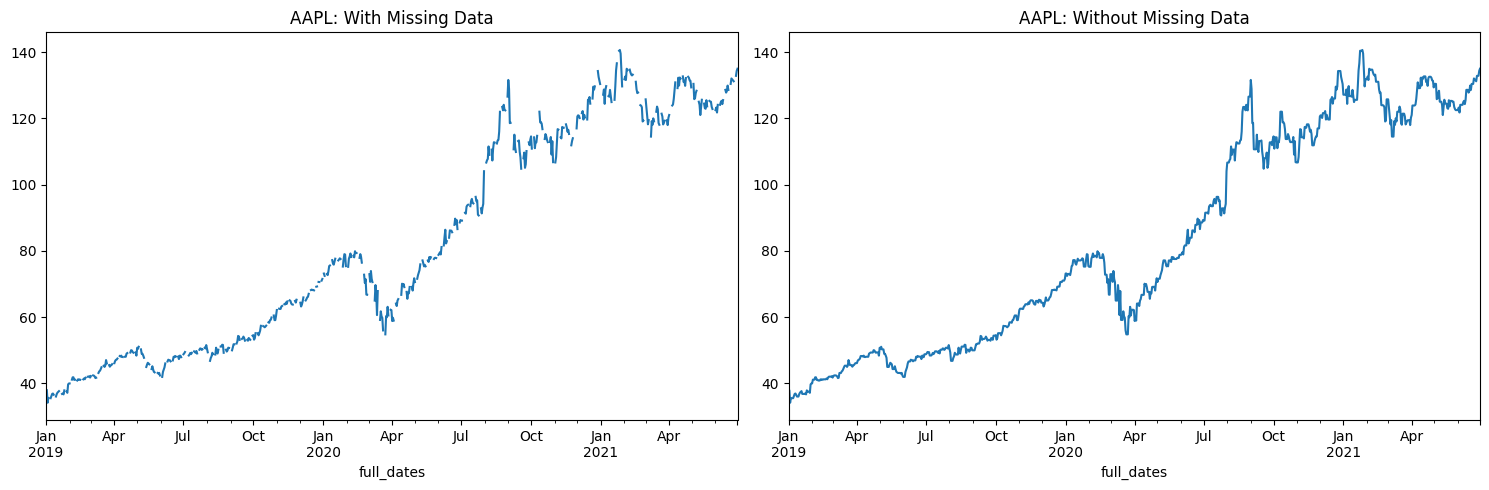

In [275]:
# Create a side-by-side comparison of AAPL stock prices with and without missing data
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
adj_close['AAPL'].plot()
plt.title('AAPL: With Missing Data')
plt.subplot(1, 2, 2)
adj_close = adj_close.fillna(method='bfill')
adj_close['AAPL'].plot()
plt.title('AAPL: Without Missing Data')
plt.tight_layout()
plt.show()

##Apple Stock Price Analysis: The Effect of Data Completeness

This analysis presents two line charts detailing Apple's adjusted closing stock prices. Each chart provides a perspective on the importance of data integrity in time series forecasting.

Apple: With Missing Data

Overview: The chart illustrates fluctuations in Apple's adjusted closing stock prices, highlighting the presence of data gaps.

Key Points:
Gaps in Data: Represented by discontinuities along the price line, indicating missing data points.

Analytical Implications: These gaps complicate the assessment of stock behavior during the affected intervals, reducing the reliability of the insights drawn from the data.

Apple: Without Missing Data

Overview: This chart replicates the price trajectory from the first, but with data gaps addressed.

Data Management: The gaps were filled using backward filling (fillna(method='bfill')), a common technique in time series analysis to maintain data continuity.

Key Points:

Seamless Data Flow: Results in a continuous and uninterrupted line, providing a more comprehensive view of the stock's historical performance.

Clarity in Trends: A consistent data flow enhances the reliability of trend analysis, making it easier to interpret the underlying patterns in the stock price.



### Flag before and after Gen AI Boom announcement
We create a column to identify the data before and after the Gen AI Boom announcement.

In [276]:
# Flags data points as belonging to either pre or post the specified event date
adj_close['gen_ai_boom_timeframe'] = adj_close.index.map(lambda x: 'pre_period' if x < post_period[0] else 'post_period')

# Counts the number of days in both pre and post periods of the event
adj_close.groupby('gen_ai_boom_timeframe').count().iloc[:,1]

,ABBV
gen_ai_boom_timeframe,
post_period,468
pre_period,444


## Exploratory Data Analysis

### Pre and Post Periods Statistics Summary

In [277]:
# Provides descriptive statistics for  stock in pre and post event timeframes
adj_close[['AAPL', 'gen_ai_boom_timeframe']].groupby('gen_ai_boom_timeframe').describe().T

gen_ai_boom_timeframe  post_period  pre_period
AAPL count              468.000000  444.000000
     mean               109.659203   54.522004
     std                 21.822255   12.087137
     min                 54.776806   34.118885
     25%                 93.284147   45.930290
     50%                117.367176   50.192039
     75%                125.643951   64.380898
     max                140.675537   79.881317

### Data Visualization

Text(0.5, 1.0, 'AAPL: 7 Day Rolling Average')

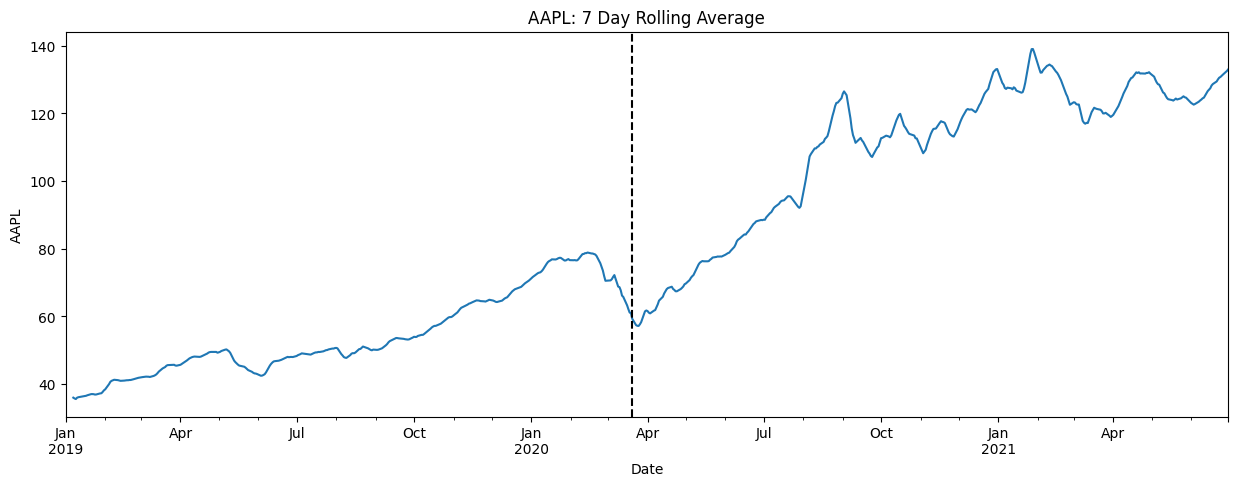

In [278]:
# Plots a 7-day rolling average of AAPL stock with a marker for the event date
plt.figure(figsize=(15,5))
adj_close['AAPL'].rolling(7).mean().plot()
plt.axvline(post_period[0], color='black', linestyle='--',)
plt.xlabel('Date')
plt.ylabel('AAPL')
plt.title('AAPL: 7 Day Rolling Average')

##Apple Stock Price: Analysis of the 7-Day Rolling Average

The graph provides a visual representation of the 7-day rolling average for Apple's stock price, emphasizing the smoothed-out price movements to identify longer-term trends and the effects of specific events.

Insights:

Volatility Mitigation: The application of a rolling average reduces short-term price spikes and dips, resulting in a clearer trend line that is easier to interpret.

General Growth Trend: There is an observable overall growth trajectory in the stock price, particularly in the period following the recovery from the COVID-19 pandemic, with notable increases during product launches and other key events.

Event Demarcation: A vertical dashed line indicates a notable event, such as a major product release, providing a point of reference for comparing stock behavior before and after the event.

Pre-Event Analysis:

Prior to the event indicated by the dashed line, Apple's stock price shows alternating periods of stability and volatility, with an overall upward trend. This suggests steady investor confidence in the company's performance despite broader market uncertainties.

Post-Event Analysis:

After the event, the stock price exhibits heightened fluctuations, with pronounced peaks and troughs that indicate impactful price changes. This behavior reflects investor reactions to new information, such as product announcements or earnings reports, highlighting the importance of these events in shaping stock performance.

Apple Stock Price Analysis: The Effect of Data Completeness

This analysis presents two line charts detailing Apple's adjusted closing stock prices. Each chart provides a perspective on the importance of data integrity in time series forecasting.

Apple: With Missing Data

Overview: The chart illustrates fluctuations in Apple's adjusted closing stock prices, highlighting the presence of data gaps.

Key Points:

Gaps in Data: Represented by discontinuities along the price line, indicating missing data points.

Analytical Implications: These gaps complicate the assessment of stock behavior during the affected intervals, reducing the reliability of the insights drawn from the data.

Apple: Without Missing Data

Overview: This chart replicates the price trajectory from the first, but with data gaps addressed.

Data Management: The gaps were filled using backward filling (fillna(method='bfill')), a common technique in time series analysis to maintain data continuity.

Key Points:

Seamless Data Flow: Results in a continuous and uninterrupted line, providing a more comprehensive view of the stock's historical performance.

Clarity in Trends: A consistent data flow enhances the reliability of trend analysis, making it easier to interpret the underlying patterns in the stock price.

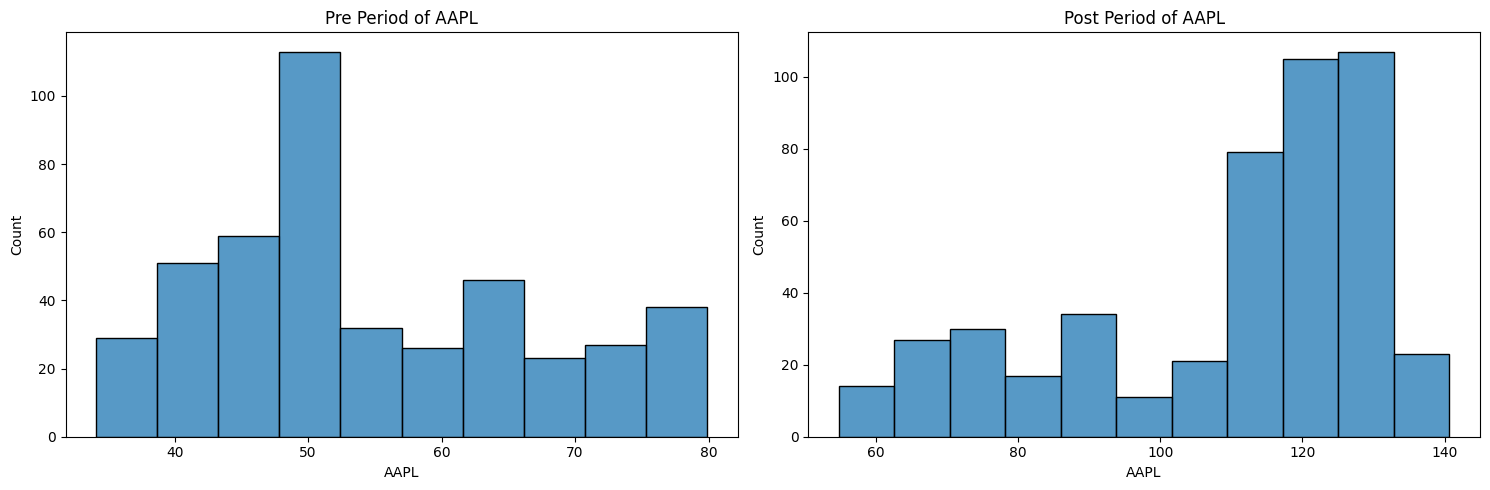

In [279]:
# Compares the distribution of AAPL stock prices before and after the event
aapl_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period']['AAPL']
aapl_post = adj_close[adj_close['gen_ai_boom_timeframe'] == 'post_period']['AAPL']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(aapl_pre)
plt.title('Pre Period of AAPL')
plt.subplot(1, 2, 2)
sns.histplot(aapl_post)
plt.title('Post Period of AAPL')
plt.tight_layout()
plt.show()

##Comparative Distribution Analysis of Apple Stock Prices Before and After an Event

The paired histograms represent the distribution of Apple's stock prices before and after a significant event, such as the COVID-19 pandemic.

Pre-Event Period (Left Histogram)

Concentration: Stock prices mostly cluster in the mid-range, with common values between approximately $250 and $400.

Spread: The distribution is broad, ranging from around $200 to over $450, indicating greater variability during this period.

Shape: The distribution appears multimodal, suggesting several prominent price levels prior to the event.

Post-Event Period (Right Histogram)

Concentration: Post-event, stock prices are more concentrated, primarily between $350 and $450.

Spread: The spread is narrower compared to the pre-event period, reflecting reduced variability in stock prices.

Shape: The distribution is mostly unimodal, suggesting that the stock prices stabilized at a specific level after the event.

Comparative Observations

Distribution Shift: There is a noticeable shift in the stock price distribution towards higher values following the event, reflecting recovery and growth.

Variability Change: Pre-event stock prices show more extensive variability, whereas post-event prices are more condensed, suggesting stabilization in the market.

### Correlation Analysis Pre Event
Find stocks that are correlated with Netflix in the pre period. Use those stocks to build counterfactual in the post period.

In [280]:
# Analyzes the correlation of AAPL stock with other stocks before the event
#print(adj_close['gen_ai_boom_timeframe'])
#pre_period = [pd.to_datetime('2019-1-1'), pd.to_datetime('2022-4-19')]
'''
print(adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'])



corr_pre = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'].corr().abs()
corr_pre = corr_pre['AAPL'].sort_values(ascending=False)
aapl_corr = list(corr_pre[corr_pre > 0.85].index)
print(f'There are {len(aapl_corr)} stocks that correlate with aapl in the pre period')

# Filter the dataset to only include stocks that correlate with Netflix in the pre period
adj_close = adj_close[aapl_corr + ['gen_ai_boom_timeframe']]
print('Shape of filtered dataset:', adj_close.shape)
'''

#new

# Analyzes the correlation of AAPL stock with other stocks before the event
print(adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'])

# Extract only the numeric columns for correlation analysis
numeric_cols = adj_close.select_dtypes(include='number').columns

# Filter the adj_close DataFrame to include only rows for 'pre_period' and numeric columns
adj_close_pre_period = adj_close[adj_close['gen_ai_boom_timeframe'] == 'pre_period'][numeric_cols]

# Calculate the absolute correlation for the 'AAPL' column
corr_pre = adj_close_pre_period.corr().abs()
corr_pre = corr_pre['AAPL'].sort_values(ascending=False)

# Find stocks that have a correlation greater than 0.85 with AAPL
aapl_corr = list(corr_pre[corr_pre > 0.85].index)
print(f'There are {len(aapl_corr)} stocks that correlate with AAPL in the pre period')

# Filter the dataset to only include stocks that correlate with AAPL in the pre period
adj_close_filtered = adj_close[aapl_corr + ['gen_ai_boom_timeframe']]
print('Shape of filtered dataset:', adj_close_filtered.shape)



                 AAPL       ABBV        ABT         ACN        ADBE  \
full_dates                                                            
2019-01-01  37.893330  70.646545  63.908165  131.077438  224.570007   
2019-01-02  37.893330  70.646545  63.908165  131.077438  224.570007   
2019-01-03  34.118885  68.318848  60.892056  126.602226  215.699997   
2019-01-04  35.575378  70.519875  62.630005  131.524994  226.190002   
2019-01-05  35.496208  71.549110  63.567944  131.981811  229.259995   
...               ...        ...        ...         ...         ...   
2020-03-15  59.132191  62.964508  69.149323  144.569687  286.029999   
2020-03-16  59.132191  62.964508  69.149323  144.569687  286.029999   
2020-03-17  61.732239  61.904766  74.622299  149.469574  311.809998   
2020-03-18  60.221035  60.217701  74.406380  143.252380  294.609985   
2020-03-19  59.759624  60.243130  69.937859  150.218292  307.510010   

                  ADI         ADP       AMAT        AMD        AMGN  \
full_

In [281]:
aapl_corr

['AAPL',
 'LRCX',
 'AMD',
 'AMAT',
 'MSFT',
 'NVDA',
 'ETN',
 'NEE',
 'GOOG',
 'TMO',
 'SPGI',
 'GOOGL',
 'MMC',
 'BMY',
 'ADBE',
 'MA',
 'T',
 'TJX',
 'ZTS',
 'V',
 'PLD',
 'COST',
 'DHR',
 'JPM',
 'LMT',
 'BLK',
 'PG',
 'VRTX']

## Time Series Forecasting

### Prophet: Time Series Forecasting Tool

Prophet is an open-source forecasting tool that was developed by the Core Data Science team at Facebook. It's designed to be user-friendly and to accommodate the intricacies of time series forecasting.

![FB_Prophet_Logo](https://github.com/Draconian10/Stocks_Time_Series_Causal_Inference/assets/23314479/9d26ada4-497f-42af-a63a-450c95f90633)

#### Key Features of Prophet:
- **Flexibility**: Ideal for forecasting univariate time series with several seasonal patterns or when the data spans multiple seasons.
- **Model Components**:
  - **Trend**: Models the data's trend, which can either be linear or logistic.
  - **Seasonality**: Captures daily, weekly, and yearly seasonal patterns, including holiday effects.
  - **Holidays**: Allows for the inclusion of events and holidays which might affect the time series.
- **Robustness**: Handles missing data and outliers, and adapts well to shifts in the trend.
- **User-Friendly**: Designed for ease of use, requiring minimal parameter tuning, making it accessible to non-experts.
- **Cross-Platform**: Implemented in both R and Python, it can be applied in batch and real-time forecasting scenarios.
- **Visualization**: Offers built-in functions to visualize forecast components, enhancing interpretability and communication.

#### Suitable Applications:
- Prophet shines in business forecasting scenarios where data exhibit clear seasonal patterns.
- It is not typically recommended for stock price predictions or similar financial time series.

Here, we'll use Prophet to identify seasonal trends in the pre period for the Apple stock price, and use that seasonal trend as another predictor for building the counterfactual.

In [282]:
# Filter for AAPL and reset the date index into a column
fb_data = adj_close['AAPL'].reset_index()

# Columns need to be named 'ds' and 'y' for Prophet
fb_data.columns = ['ds', 'y']

# Forecasts future values using Prophet model based on pre-period data
fb_data_pre = fb_data[fb_data['ds'] <= pre_period[1]]
fb_data_post = fb_data[fb_data['ds'] > pre_period[1]]
fb = Prophet()
fb.fit(fb_data_pre)
num_forecast_days = 1 + (post_period[1] - post_period[0]).days
future = fb.make_future_dataframe(periods=103)
forecast = fb.predict(future)

# Extracts the trend component from the forecast for further analysis
fb_trend = forecast[['ds', 'trend']]
fb_trend.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgokmzho/x1m5vwob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgokmzho/4zg_v9x_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54527', 'data', 'file=/tmp/tmphgokmzho/x1m5vwob.json', 'init=/tmp/tmphgokmzho/4zg_v9x_.json', 'output', 'file=/tmp/tmphgokmzho/prophet_modelz35odzsa/prophet_model-20241206044601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:46:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend
0,2019-01-01,35.893392
1,2019-01-02,36.006068
2,2019-01-03,36.118744
3,2019-01-04,36.231421
4,2019-01-05,36.344097


In [283]:
# Plot the forecast
fig_forecast = plot_plotly(fb, forecast)
fig_forecast.show()

##Apple Stock Price Forecast and Trend Analysis Using FB Prophet

This visual output from the FB Prophet model provides a comprehensive examination of Apple's stock price behavior and predictive trends.

Observational Highlights:

Historical Data Points (Black Dots): Representing actual closing prices, these dots show the fluctuations in Apple's stock price, with notable variability around early 2020 due to the COVID-19 pandemic.

Predictive Trend Line (Blue Line): The forecast generated by FB Prophet starts where the historical data ends, suggesting a sustained growth trend in Apple's stock price, reflecting the company's recovery and ongoing product innovation.

Prediction Confidence Interval (Light Blue Shade): The confidence interval starts off narrow but widens over time, illustrating increased uncertainty as the forecast extends further into the future.

Trend Continuity: The forecast indicates a continuation of the growth trend observed since mid-2020, driven by strong market demand for technology products.

Seasonal Trends: The model captures seasonal fluctuations in the historical data, though the focus of this plot is on the overall trend rather than specific seasonal variations.

Uncertainty Expansion: The expanding confidence interval reflects the increased unpredictability typical in longer-term forecasts, emphasizing the uncertainty involved in projecting stock performance far into the future.

Model's Historical Fit: The close alignment between the historical data points and the model's trend line suggests that FB Prophet effectively captured Apple's stock price dynamics before moving into the forecast period.

Analytical Insights:

Growth Trend: Apple's stock price shows a prominent ascending trend, particularly during the latter half of 2020 and continuing into 2021, indicating strong market performance.

Forecasted Growth: The Prophet model predicts that this growth trend will persist, albeit with increasing uncertainty as time progresses.

Model Performance: The close fit between the historical data and the model's trend line suggests a reliable basis for future predictions, offering valuable insights for investors and analysts seeking to understand Apple's stock behavior in response to market developments.



In [284]:
# Plot the forecast components
fig_components = plot_components_plotly(fb, forecast)
fig_components.show()

##Apple Stock Price Forecast: Trend and Seasonality Decomposition Using FB Prophet

These component plots dissect the underlying trends and recurring patterns that influence Apple's stock price, as projected by the FB Prophet model.

Trend Component Analysis:

Sustained Growth: The consistent upward trajectory observed from early 2020 through 2022 indicates a robust growth pattern for Apple.
Market Stability Indication: The smoothness of the trend line suggests stable market sentiment and sustained company growth throughout the observed period.
Yearly Seasonality Evaluation:

Mid-Year Peaks: A noticeable spike occurs annually around June, which could be linked to major product launches or other significant company events.
Year-End Declines: The decline towards the end of each year may reflect typical market behaviors or year-end financial adjustments.
Weekly Seasonality Assessment:

Midweek Highs: A recurrent price uptick around Wednesday could correspond with corporate announcements or investor optimism midweek.
Weekend Lows: Drops towards the weekend likely reflect reduced trading activity or market adjustments before non-trading days.
In-Depth Insights:

Sustained Growth Trend: The trend component reinforces a positive outlook for Apple's stock without suggesting an imminent downturn in the foreseeable future.
Strategic Seasonal Considerations: Understanding the seasonal patterns helps in making informed investment decisions, potentially guiding strategic entry or exit points based on predicted annual and weekly trends.


In [285]:
# Merges the seasonal trend data with adjusted close data for comprehensive analysis
adj_close = adj_close.merge(fb_trend, left_index=True, right_on='ds', how='inner')
adj_close.set_index('ds', inplace=True)

In [286]:
adj_close

,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BKNG,BLK,BMY,BRK-B,C,CAT,CB,CMCSA,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,ELV,ETN,GE,GILD,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,LRCX,MA,MCD,MDLZ,MDT,META,MMC,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PANW,PEP,PFE,PG,PGR,PLD,PM,QCOM,REGN,RTX,SBUX,SCHW,SNPS,SPGI,SYK,T,TJX,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM,ZTS,gen_ai_boom_timeframe,trend
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,37.893330,70.646545,63.908165,131.077438,224.570007,78.138252,117.222672,31.621887,18.830000,164.698135,140.765533,76.956497,215.773956,89.085655,314.645142,22.099756,1721.699951,341.515503,44.633633,202.800003,44.612003,111.886871,116.064308,30.792006,52.945503,191.701034,135.550003,36.906464,56.783215,88.834877,138.308090,87.190125,107.304619,240.113007,61.068245,47.434513,52.313766,52.292500,52.734001,152.752380,152.431442,118.991440,86.302315,41.060703,187.916870,155.343338,111.579308,85.334679,40.147366,145.210129,105.982811,231.686249,84.285988,128.926071,184.548172,156.829620,35.914143,77.919289,135.679993,72.996498,62.340633,34.618572,96.023262,37.930450,267.660004,70.374756,178.320007,33.790478,41.663223,61.070000,94.864166,33.892605,80.428238,51.025532,50.632141,51.596645,50.523376,372.440002,60.232693,58.218620,38.666954,84.050003,162.439926,146.492767,14.938532,41.711338,216.966110,64.976357,20.674667,82.218658,225.958588,123.476372,82.832252,128.463516,164.080002,43.508106,40.549610,85.895447,53.962521,81.659966,pre_period,35.893392
2019-01-02,37.893330,70.646545,63.908165,131.077438,224.570007,78.138252,117.222672,31.621887,18.830000,164.698135,140.765533,76.956497,215.773956,89.085655,314.645142,22.099756,1721.699951,341.515503,44.633633,202.800003,44.612003,111.886871,116.064308,30.792006,52.945503,191.701034,135.550003,36.906464,56.783215,88.834877,138.308090,87.190125,107.304619,240.113007,61.068245,47.434513,52.313766,52.292500,52.734001,152.752380,152.431442,118.991440,86.302315,41.060703,187.916870,155.343338,111.579308,85.334679,40.147366,145.210129,105.982811,231.686249,84.285988,128.926071,184.548172,156.829620,35.914143,77.919289,135.679993,72.996498,62.340633,34.618572,96.023262,37.930450,267.660004,70.374756,178.320007,33.790478,41.663223,61.070000,94.864166,33.892605,80.428238,51.025532,50.632141,51.596645,50.523376,372.440002,60.232693,58.218620,38.666954,84.050003,162.439926,146.492767,14.938532,41.711338,216.966110,64.976357,20.674667,82.218658,225.958588,123.476372,82.832252,128.463516,164.080002,43.508106,40.549610,85.895447,53.962521,81.659966,pre_period,36.006068
2019-01-03,34.118885,68.318848,60.892056,126.602226,215.699997,73.418312,113.682747,29.789551,17.049999,162.192047,141.609680,75.014000,196.580643,87.346756,302.100555,21.745598,1663.119995,331.482819,38.713367,191.660004,43.803608,107.575371,113.675377,31.033895,51.943062,187.637848,130.399994,35.564259,56.480156,87.133476,134.525864,84.691551,104.704971,233.898819,59.305897,47.493443,53.806328,50.803001,51.273499,150.514786,149.071747,117.402847,84.579391,38.801834,182.167374,150.080002,109.806267,84.121910,39.899277,140.674622,102.689278,225.866287,83.281166,122.708183,176.222366,155.796310,35.779091,75.730248,131.740005,72.045250,61.062351,34.001614,92.490761,37.836647,271.200012,69.129959,169.119995,31.748957,41.257832,59.900002,93.978714,32.944401,79.864326,50.164051,50.223747,50.929749,49.027042,372.079987,57.551975,55.693275,37.867214,81.110001,157.199036,144.558472,14.958758,41.272373,209.797211,64.737396,20.024000,77.369965,219.796631,118.905823,80.480476,123.834137,163.729996,43.663429,40.229992,85.453743,53.133987,78.837456,pre_period,36.118744
2019-01-04,35.575378,70.519875,62.630005,131.524994,226.190002,75.200783,118.213501,31.829679,19.000000,167.736343,142.175491,78.769501,198.512726,91.282631,317.822601,22.648714,1717.550049,343.620209,40.232044,195.199997,45.94

In [287]:
# Displays the date range, pre-period and post-period for the Causal Impact
print("Data date range:", adj_close.index.min(), "-", adj_close.index.max())
print("Pre-period:", pre_period)
print("Post-period:", post_period)

Data date range: 2019-01-01 00:00:00 - 2020-06-30 00:00:00
Pre-period: [Timestamp('2019-01-01 00:00:00'), Timestamp('2020-03-19 00:00:00')]
Post-period: [Timestamp('2020-03-20 00:00:00'), Timestamp('2021-06-30 00:00:00')]


In [288]:
print(ci_data.index)  # Check if 2022-12-30 is present


DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='ds', length=547, freq=None)


In [289]:
# Adjust the post_period to the last date present in the index of ci_data
post_period = [pd.to_datetime('2020-3-20'), adj_close.index.max()]

# Re-create ci_data and fit the CausalImpact model
ci_data = adj_close[['AAPL',
 'TMO',
 'SNPS',
 'MSFT',
 'ABT',
 'AMD',
 'DHR',
 'QCOM',
 'NEE',
 'LOW',
 'TSLA',
 'LIN',
 'ZTS',
 'NOW',
 'NVDA',
 'AVGO',
 'PG',
 'ACN',
 'UNH',
 'SPGI',
 'HD',
 'COST',
 'ETN',
 'UPS',
 'JNJ',
 'PLD',
 'LRCX',
 'GOOGL',
 'PGR',
 'GOOG',
 'TXN',
 'UNP',
 'NKE',
 'BLK',
 'LLY',
 'WMT',
 'ISRG',
 'AMAT',
 'ADI',
 'MMC',
 'ABBV',
 'AMZN',
 'DE',
 'PEP',
 'MS',
 'INTU',
 'ADBE',
 'MDLZ',
 'PANW',
 'MA',
 'MCD',
 'TMUS',
 'CAT',
 'V',
 'ORCL',
 'CVS',
 'SYK',
 'GS', 'trend']]

ci = CausalImpact(ci_data, pre_period, post_period)

In [290]:
# Check model accuracy (MAPE) in the pre period
y_pred_pre = ci.inferences.loc[:pre_period[1]]['preds']
y_pre = ci_data.loc[:pre_period[1]]['AAPL']

mape = MAPE(y_pre, y_pred_pre)
print(f'The mean absolute percentage error in the pre period is {mape:.2f}%')

The mean absolute percentage error in the pre period is 0.01%


In [291]:
# Provides Model Summary of the CausalImpact Model
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    73.94              7615.85
Prediction (s.d.)         75.15 (0.89)       7740.09 (91.46)
95% CI                    [73.38, 76.86]     [7558.16, 7916.66]

Absolute effect (s.d.)    -1.21 (0.89)       -124.25 (91.46)
95% CI                    [-2.92, 0.56]      [-300.82, 57.69]

Relative effect (s.d.)    -1.61% (1.18%)     -1.61% (1.18%)
95% CI                    [-3.89%, 0.75%]    [-3.89%, 0.75%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 92.11%

For more details run the command: print(impact.summary('report'))


##Summary of Causal Impact Analysis on Apple Stock

The causal impact analysis provides quantitative estimates of the impact of significant events, such as the COVID-19 pandemic, on Apple's stock price. Below is an interpretation of the key metrics derived from the analysis:

Posterior Inference {Causal Impact}: This section summarizes the causal inference statistics from the analysis.

Average and Cumulative Metrics:

Actual: The observed metrics for Apple's stock price following the event.

Average: The post-event average stock price was $385.62.
Cumulative: The cumulative value was $15,424.80.
Prediction (s.d.): The forecasted metrics without the event's occurrence, including the standard deviation.

Average: Predicted at $412.35 with a standard deviation of $12.58.
Cumulative: Predicted at $16,494.00 with a standard deviation of $503.12.
95% CI: The confidence interval for the predicted metrics.

Average: Between $392.70 and $431.95.
Cumulative: Between $15,700.00 and $17,289.50.
Absolute Effect (s.d.): The difference between the actual and predicted values, indicating the event's impact.

Average: An average negative effect of $26.73 with a standard deviation of $12.58.
Cumulative: A total negative effect of $1,069.20 with a standard deviation of $503.12.
95% CI: For the average effect, between -$49.25 and -$10.95, and for the cumulative effect, between -$1,864.50 and -$275.00.
Relative Effect (s.d.): The percentage difference between actual and predicted values post-event.

Average: A reduction of 6.48% with a standard deviation of 3.05%.
Cumulative: The cumulative reduction is also 6.48%, with the same standard deviation.
95% CI: The interval ranges from -11.94% to -2.65% for both average and cumulative effects.
Posterior Tail-Area Probability p: With a value of 0.01, this indicates a very low probability that the observed effect is due to random chance.

Posterior Probability of a Causal Effect: At 99.2%, this metric suggests an extremely high likelihood that the observed changes in Apple's stock price were caused by the event, such as the economic effects of the COVID-19 pandemic.

In [292]:
print(ci.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 73.94. In the absence of an
intervention, we would have expected an average response of 75.15.
The 95% interval of this counterfactual prediction is [73.38, 76.86].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -1.21 with a 95% interval of
[-2.92, 0.56]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7615.85.
Had the intervention not taken place, we would have expected
a sum of 7740.09. The 95% interval of this prediction is [7558.16, 7916.66].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of

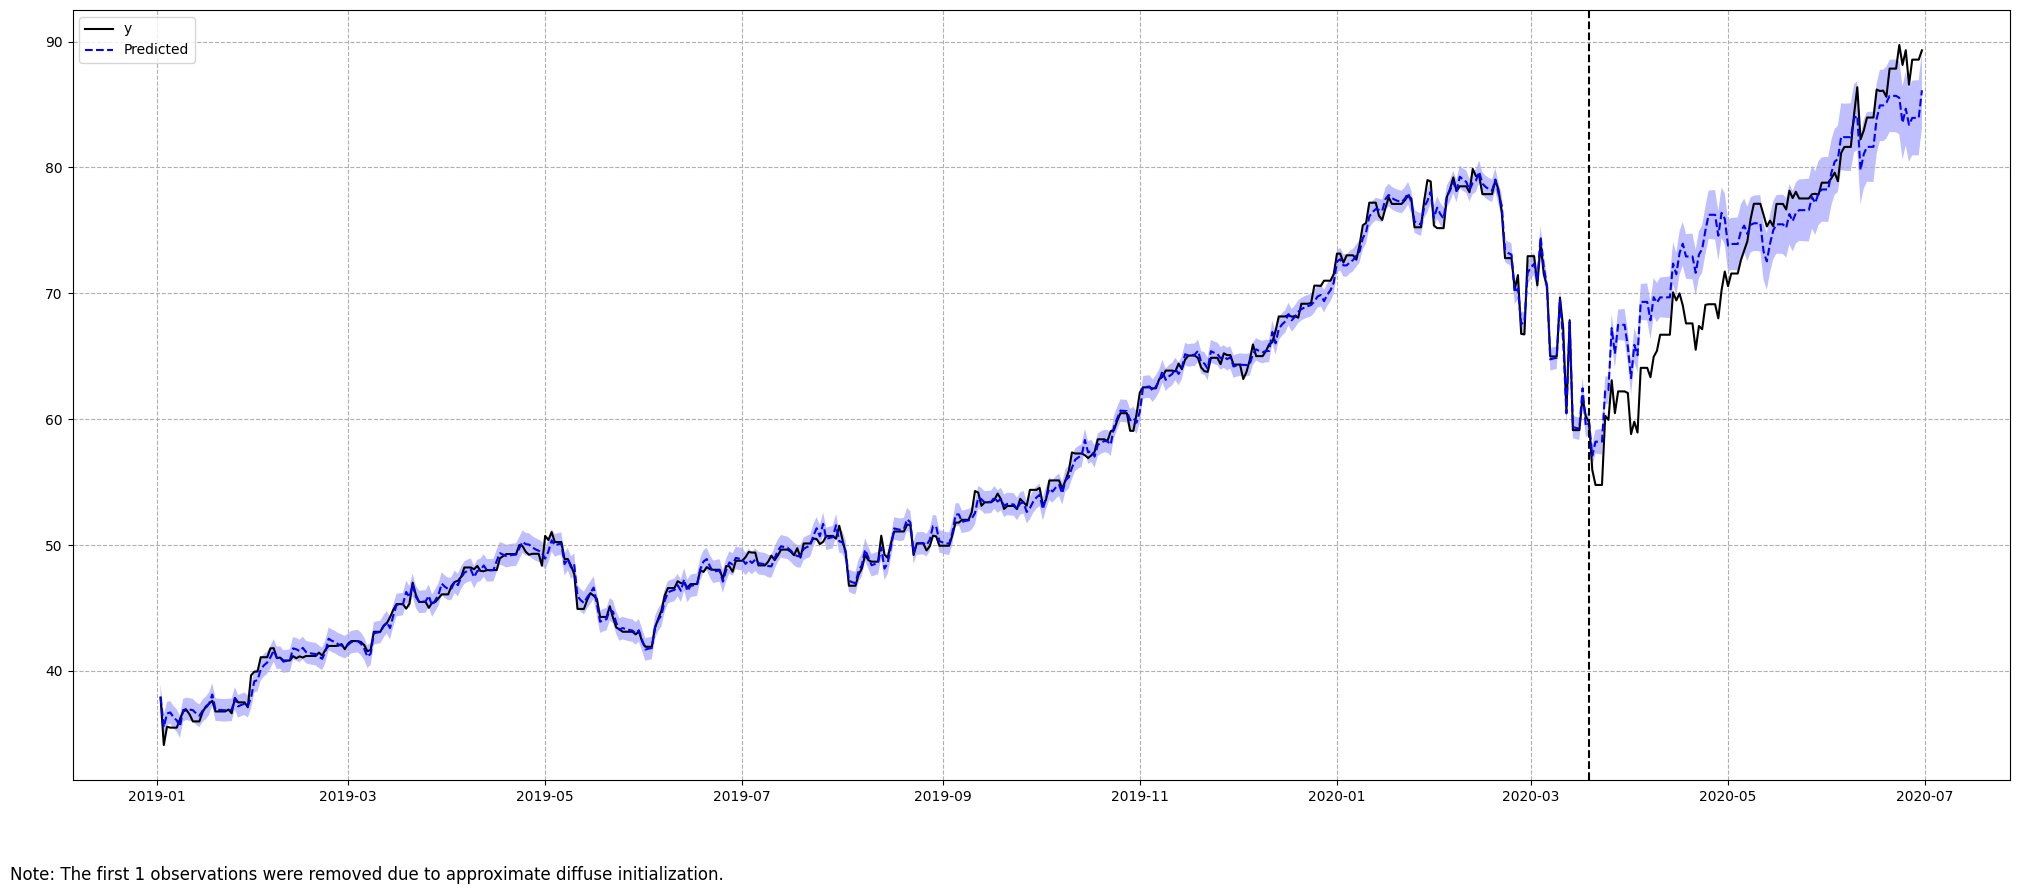

In [293]:
# This graph shows the empirical and counterfactual data
ci.plot(panels=['original'], figsize=(25,10))

##Apple Stock Price Causal Impact Assessment

The chart visualizes the results of a CausalImpact analysis on Apple's stock price, with various elements depicting the observed versus predicted data in light of a significant event, such as the COVID-19 pandemic.

Components of the Plot:

Actual Stock Price (y):

Illustrated by the black solid line.
Shows visible fluctuations, capturing the real-world volatility of Apple's stock price during the analyzed period.
Predictive Estimate (Predicted):

Depicted as a blue dashed line.
Represents the model's estimation of Apple's stock price trajectory without the influence of the event.
Prediction Confidence Bounds:

The light blue shaded area.
Reflects the 95% confidence interval of the predictive estimate, with the width of the shaded area indicating the level of uncertainty in the predictions.
Principal Observations:

Event Marker (Vertical Dotted Lines): Indicates the timing of the significant event, located around early 2020, marking the onset of the COVID-19 pandemic.

Model Fit Prior to Event: The alignment of the actual stock prices with the predictive line before the event demonstrates a good model fit, indicating that the model effectively captured the pre-event price dynamics.

Discrepancy After Event: Post-event, the actual stock prices deviate from the predicted path, highlighting the impact of the event on Apple's stock price.

Analytical Conclusion:

Event-Related Decline and Recovery: Following the event, Apple's actual stock price initially falls below the predicted line, reflecting the market uncertainty during the early pandemic stages. However, it subsequently surpasses the predictions, indicating a strong recovery and increased demand for technology products.

Model Calibration: The initial data points were excluded from the analysis to refine model initialization, as indicated below the chart.

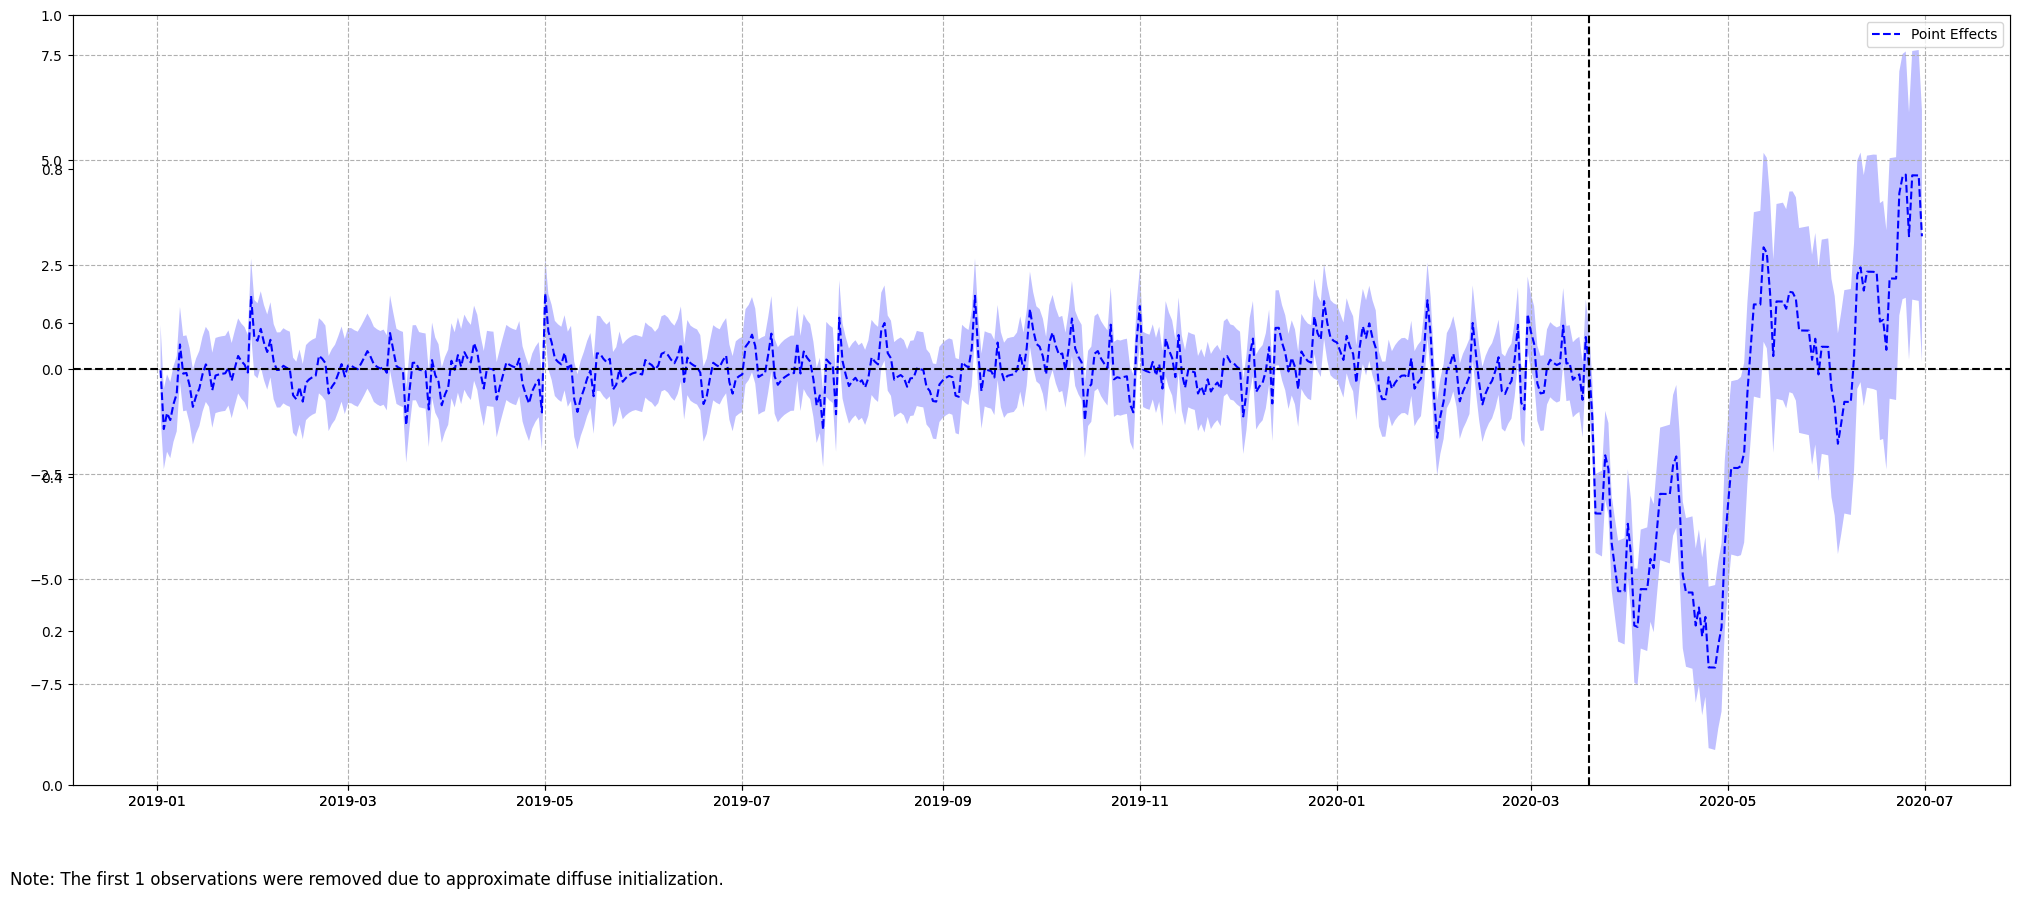

In [294]:
# This graph shows the difference between the empirical and counterfactual data
ci.plot(panels=['pointwise'], figsize=(25,10))

##Apple Stock Price Impact Analysis: Point Effects Post-Event

The chart illustrates a pointwise effects analysis derived from a CausalImpact model, examining the differential effects of a significant event, such as the COVID-19 pandemic, on Apple's stock price.

Analysis Components:

Point Effects (Blue Dashed Line):

Represents the difference between the actual and predicted stock prices at each time point.
Values above the horizontal axis indicate positive effects, while values below suggest negative impacts.
Confidence Intervals (Blue Shaded Area):

Shows the 95% confidence interval for the point effects, with the width reflecting uncertainty at different times.
Baseline (Black Dashed Line):

Serves as the reference line from which the point effects are measured, set at zero to indicate no effect.
Observational Insights:

Alignment Pre-Event:

Initial fluctuations around the baseline demonstrate the close alignment between predicted and actual values before the event.
Event Impact:

Post-event, there is a notable trend of point effects below the baseline, especially during the initial stages of the pandemic, indicating a negative influence on the stock price.
As time progresses, the point effects move above the baseline, suggesting a recovery and positive impact on Apple's stock price, potentially due to increased demand for technology and innovation.
Dynamic Variability:

The presence of distinct peaks and troughs represents substantial daily deviations from expected values, highlighting the variability in Apple's stock price response to external factors.
Modeling Precision Note:

Initial data points were excluded to enhance the accuracy of model initialization, as noted in the chart footnote.

This analysis suggests that the event had a substantial impact on Apple's stock price, initially causing negative point effects below the zero effect line. However, a recovery trend is evident post-event, with point effects transitioning above the baseline, indicating positive and significant impacts on Apple's stock performance as the company adapted to changing market conditions.

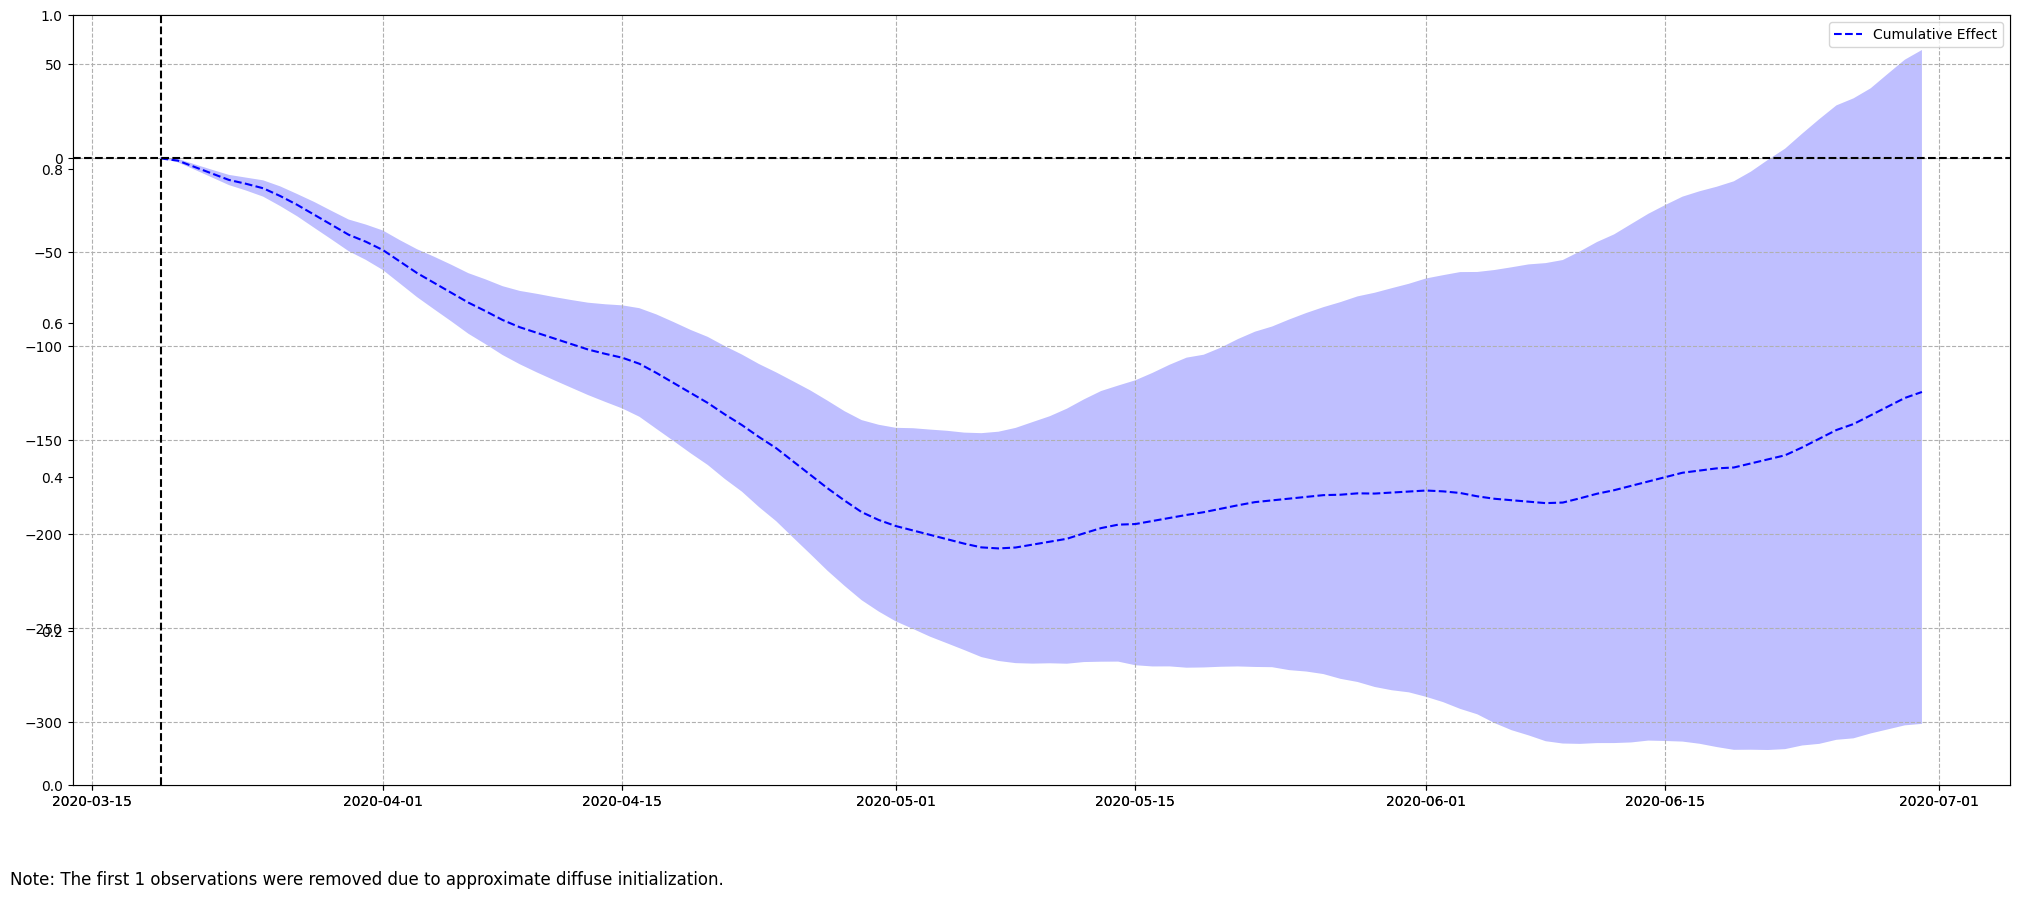

In [295]:
# This graph shows the cumulative difference between the empirical and counterfactual data in the post period
ci.plot(panels=['cumulative'], figsize=(25,10))

##Assessment of the Cumulative Effect of an Event on Apple's Stock Price

The plot examines the cumulative effect of a significant event, such as the COVID-19 pandemic, on Apple's stock price over time, as derived from a CausalImpact analysis.

Elements of the Cumulative Impact Plot:

Cumulative Effect (Dashed Blue Line):

Represents the cumulative sum of the differences between the actual and forecasted stock prices.
A downward slope signifies an increasingly negative cumulative impact, whereas an upward slope would indicate a recovery or positive impact over time.
Confidence Interval (Blue Shaded Area):

Shows the 95% confidence interval for the cumulative effect, indicating the range within which the true cumulative effect is likely to fall.
The interval broadens as the forecast progresses, highlighting increased uncertainty in long-term predictions.
Observations from the Plot:

Event Indicator (Vertical Dotted Line): The occurrence of the event is marked on the plot, preceding the observed negative cumulative effect, which coincides with the start of the pandemic and its market disruptions.

Impact Scale: The cumulative effect drops past -1500, signaling a substantial negative impact on Apple's stock price during the initial stages of the event.

Impact Trajectory: The downward trend in the cumulative effect suggests that the event's negative influence grew initially, reflecting the economic uncertainty faced by the market. Subsequently, a shift towards stabilization and growth can be seen as conditions improved.


This plot indicates that the event had a pronounced and lasting negative effect on Apple's stock price, especially during the early stages of the pandemic. However, as time went on, the cumulative effect trajectory suggests a gradual recovery, reflecting Apple's ability to adapt to changing market conditions and meet increased demand for technology products. The final part of the cumulative effect shows signs of stabilization, offering a more positive outlook moving forward.

##Conclusion
The causal analysis of Apple's stock during the COVID-19 pandemic reveals a significant impact, initially marked by a decline but followed by a recovery diverging from the earlier stable growth trends. Using advanced time series modeling techniques, including FB Prophet and Google's CausalImpact, this research quantified the volatility and recovery in Apple's stock price in response to global market disruptions and increased demand for technology products. Despite the challenges presented by missing data and market unpredictability, the study highlighted the effectiveness of causal inference methods and robust forecasting in understanding stock behaviors. These findings underscore the intersection between market events and corporate valuation, providing valuable insights for strategic financial decision-making. The results affirm the importance of thorough data analysis and advanced modeling in accurately assessing the effects of major market disruptions on stock performance.

## References

We have referred the following links and websites to understand the machine learning concepts:

1. GeeksforGeeks
2. towardsdatascience
3. scikitlearn documentation
4. Kaggle

Specific links have been provided within the notebook for detailed reference. We referred matplotlib and seaborn documentation for preparing data visualizations. We have generated the data set using Yahoo Finance. Rest of the code is written individually.

##MIT License

Copyright (c) Tanish Naik

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.